In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
"""import SimpleITK as sitk
import numpy as np
import random\
import os
import glob

def apply_augmentation(image, translation_range, rotation_angle, noise_std):
  translation_range = [5, 5, 5]  # Maximum translation along each axis
  rotation_angle = [15, 15, 15]  # Maximum rotation angles in degrees
  noise_std = 10.0  # Standard deviation of Gaussian noise

# Input and output directories
input_folder = "/content/drive/MyDrive/trainingdata/train/temp_images"
output_folder = "/content/drive/MyDrive/trainingdata/train/aug_images"

# List all the image files in the input folder
image_files = glob.glob(os.path.join(input_folder, "*.nii.gz"))

# Loop through each image and apply augmentation
for input_path in image_files:
    print("Augmenting image:", input_path)

    # Load the 3D image using SimpleITK
    image = sitk.ReadImage(input_path)

    # Apply augmentation
    augmented_image = apply_augmentation(image, translation_range, rotation_angle, noise_std)

    # Generate an output path for the augmented image
    image_filename = os.path.basename(input_path)
    output_path = os.path.join(output_folder, "augmented_" + image_filename)

    # Save the augmented image
    sitk.WriteImage(augmented_image, output_path)

    # Apply a random rotation to the rotation angles for the next iteration
    random_rotation = [random.uniform(-r, r) for r in rotation_angle]
    rotation_angle = random_rotation

print("Data augmentation complete.")"""


'import SimpleITK as sitk\nimport numpy as np\nimport randomimport os\nimport glob\n\ndef apply_augmentation(image, translation_range, rotation_angle, noise_std):\n  translation_range = [5, 5, 5]  # Maximum translation along each axis\n  rotation_angle = [15, 15, 15]  # Maximum rotation angles in degrees\n  noise_std = 10.0  # Standard deviation of Gaussian noise\n\n# Input and output directories\ninput_folder = "/content/drive/MyDrive/trainingdata/train/temp_images"\noutput_folder = "/content/drive/MyDrive/trainingdata/train/aug_images"\n\n# List all the image files in the input folder\nimage_files = glob.glob(os.path.join(input_folder, "*.nii.gz"))\n\n# Loop through each image and apply augmentation\nfor input_path in image_files:\n    print("Augmenting image:", input_path)\n\n    # Load the 3D image using SimpleITK\n    image = sitk.ReadImage(input_path)\n\n    # Apply augmentation\n    augmented_image = apply_augmentation(image, translation_range, rotation_angle, noise_std)\n\n    

In [ ]:
#3d unet model

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.layers import Activation, LeakyReLU

kernel_initializer = 'he_uniform' # Try others if you want

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    # Compile model outside of this function to make it flexible.
    return model

# Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 1, 2)
model.summary()
# 1 img channels scans
# 2 num classes in mask
print(model.input_shape)
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  448         ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

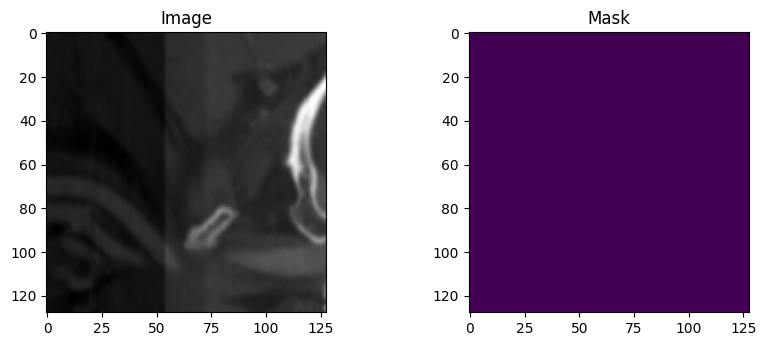

In [ ]:
# Custom Datagenerator
#from tifffile import imsave, imread

import os
import numpy as np

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image_path = os.path.join(img_dir, image_name)
            image = np.load(image_path)
            images.append(image.astype(np.float32))
    images = np.array(images)
    return(images)

def load_img(mask_dir, mask_list):
    masks = []
    for i, mask_name in enumerate(mask_list):
        if mask_name.split('.')[1] == 'npy':
            mask_path = os.path.join(mask_dir, mask_name)
            mask = np.load(mask_path)
            # Update to match the number of classes (channels) in your model's output
            mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension
            masks.append(mask.astype(np.float32))  # Convert to float32
    masks = np.array(masks)
    return masks


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
     L = len(img_list)
     while True:
 #keras needs the generator infinite, so we will use while true
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size


#Test the generator
from matplotlib import pyplot as plt
import random

train_img_dir = '/content/drive/MyDrive/trainingdata/train/temp_images'
train_mask_dir = '/content/drive/MyDrive/trainingdata/train/temp_mask'
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 3

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)


#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]

# random gen
n_slice=random.randint(0, test_mask.shape[2]-1)
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.imshow(test_img[n_slice], cmap='gray')
plt.title('Image')
plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Training


In [ ]:
!pip install segmentation-models-3D


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
# Importing modules

import os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import keras
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


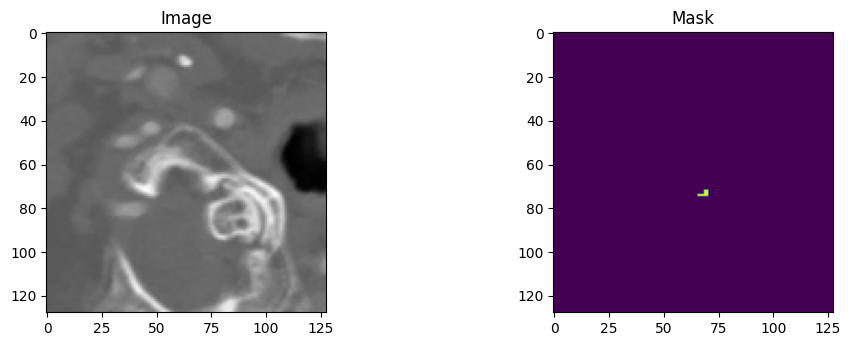

In [ ]:

"""
@author:  Rahul Rakesh

Code to train batches of cropped BraTS 2020 images using 3D U-net.

Please get the data ready and define custom data gnerator using the other
files in this directory.

Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)

Masks are expected to be 128x128x128x2 npy data (2 corresponds to the 2 classes / labels)


You can change input image sizes to customize for your computing resources.
"""


####################################################
# defining directories
train_img_dir = '/content/drive/MyDrive/trainingdata/train/temp_images/'
train_mask_dir = '/content/drive/MyDrive/trainingdata/train/temp_mask/'
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)

test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])

n_slice=random.randint(0, test_mask.shape[1])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image')
plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:

####################################################

#Define the image generators for training and validation

train_img_dir = '/content/drive/MyDrive/trainingdata/train/temp_images/'
train_mask_dir = '/content/drive/MyDrive/trainingdata/train/temp_mask/'

val_img_dir = '/content/drive/MyDrive/trainingdata/val/temp_images/'
val_mask_dir = '/content/drive/MyDrive/trainingdata/val/temp_mask/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 4

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)


####################################################
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


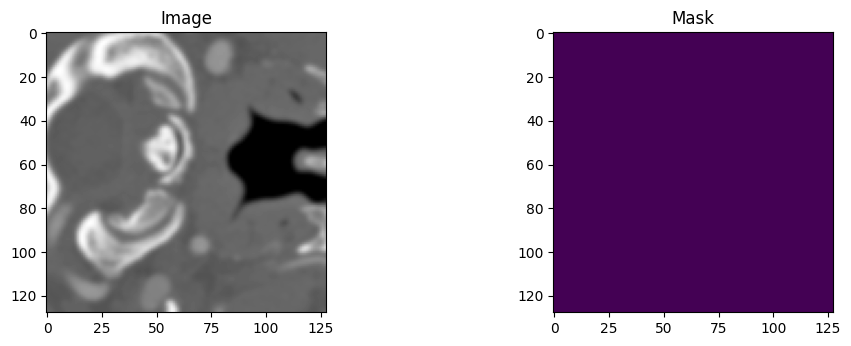

In [ ]:

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image')
plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
 #defining loss funtion metrics and optymizer for training

import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss()

#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.001
optim = keras.optimizers.Adam(LR)

#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



In [ ]:
# 3d unet model
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=1,
                          num_classes=2)


model.compile(optimizer = optim, loss=dice_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

##################################################################


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  448         ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [ ]:
betext2=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
model.save('brainmaskext2_3d.hdf5')

Epoch 1/100
3/3 [==============================] - 78s 18s/step - loss: 0.7827 - accuracy: 0.0933 - iou_score: 0.1245 - val_loss: 0.4895 - val_accuracy: 0.7840 - val_iou_score: 0.3429
Epoch 2/100
3/3 [==============================] - 7s 2s/step - loss: 0.8319 - accuracy: 0.9500 - iou_score: 0.0942 - val_loss: 0.4893 - val_accuracy: 0.9712 - val_iou_score: 0.3430
Epoch 3/100
3/3 [==============================] - 7s 3s/step - loss: 0.8512 - accuracy: 0.9818 - iou_score: 0.0868 - val_loss: 0.4906 - val_accuracy: 0.9518 - val_iou_score: 0.3417
Epoch 4/100
3/3 [==============================] - 7s 2s/step - loss: 0.8040 - accuracy: 0.9521 - iou_score: 0.1142 - val_loss: 0.4944 - val_accuracy: 0.8907 - val_iou_score: 0.3384
Epoch 5/100
3/3 [==============================] - 6s 2s/step - loss: 0.7677 - accuracy: 0.9001 - iou_score: 0.1336 - val_loss: 0.4949 - val_accuracy: 0.8974 - val_iou_score: 0.3379
Epoch 6/100
3/3 [==============================] - 7s 3s/step - loss: 0.8263 - accuracy:

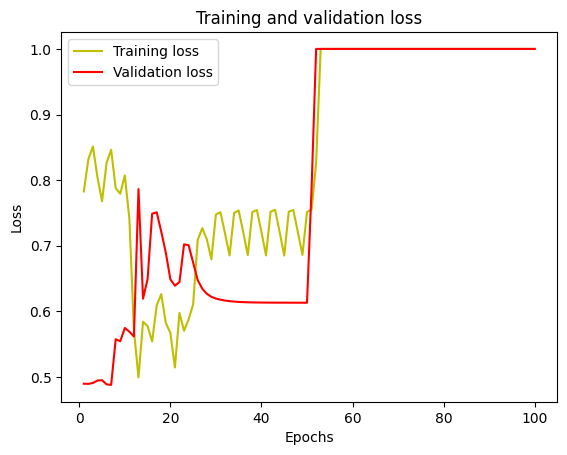

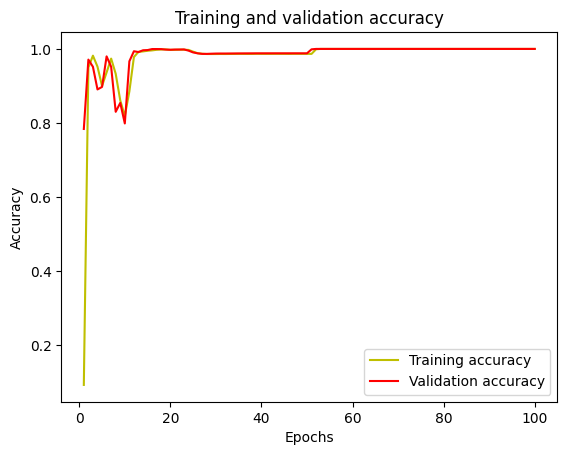

In [ ]:
#plot the training and validation IoU and loss at each epoch

loss = betext2.history['loss']
val_loss = betext2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = betext2.history['accuracy']
val_acc = betext2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
from keras.models import load_model
import segmentation_models_3D as sm

# Define your custom objects in a dictionary
custom_objects = {
    'dice_loss': sm.losses.DiceLoss(),
    'iou_score': sm.metrics.IOUScore(threshold=0.5)
}

# Load the model using the custom objects
my_model = load_model('/content/brainmaskext2_3d.hdf5', custom_objects=custom_objects)

# Define other parameters
LR = 0.001
optim = keras.optimizers.Adam(LR)

# Rest of your code...



In [ ]:
# training 2nd time
my_model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5)])

# Now all set to continue the training process.

#Now all set to continue the training process.
bet2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=60,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/60
3/3 [==============================] - 9s 3s/step - loss: 143859449856.0000 - accuracy: 1.0000 - iou_score: 1.7379e-11 - val_loss: 3393235456.0000 - val_accuracy: 1.0000 - val_iou_score: 3.4764e-12
Epoch 2/60
3/3 [==============================] - 7s 2s/step - loss: 1049924352.0000 - accuracy: 0.9986 - iou_score: 0.0262 - val_loss: 67453424.0000 - val_accuracy: 0.9951 - val_iou_score: 0.0921
Epoch 3/60
3/3 [==============================] - 7s 3s/step - loss: 4519587.0000 - accuracy: 0.9400 - iou_score: 0.1866 - val_loss: 802966.0000 - val_accuracy: 0.9892 - val_iou_score: 0.0164
Epoch 4/60
3/3 [==============================] - 7s 3s/step - loss: 469719.0938 - accuracy: 0.9961 - iou_score: 0.0155 - val_loss: 117303.0781 - val_accuracy: 0.9998 - val_iou_score: 1.2162e-04
Epoch 5/60
3/3 [==============================] - 7s 2s/step - loss: 123780.2188 - accuracy: 0.9993 - iou_score: 2.4007e-04 - val_loss: 4344.8706 - val_accuracy: 0.9961 - val_iou_score: 1.3905e-05
Epoch 6/60

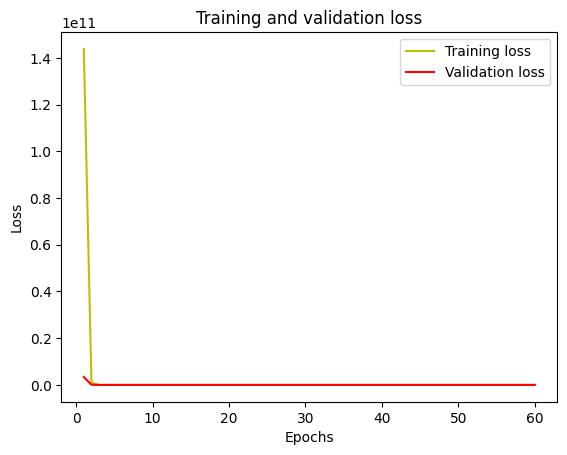

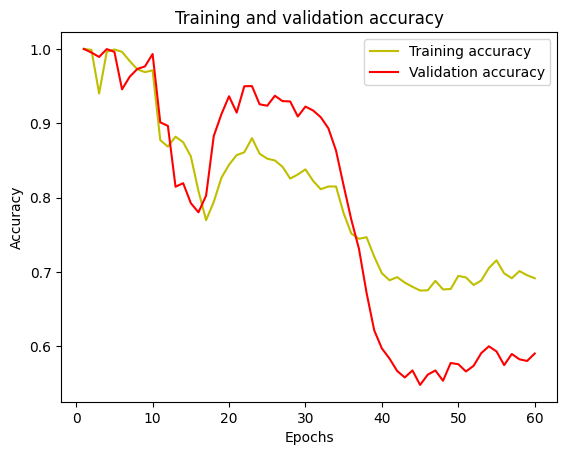

In [ ]:
#plot the training and validation IoU and loss at each epoch

loss = bet2.history['loss']
val_loss = bet2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = bet2.history['accuracy']
val_acc = bet2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/brainmaskext2_3d.hdf5',compile=False)


In [ ]:

#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=5 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()


test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 12s 12s/step
Mean IoU = 1.0


# New section

In [ ]:
img_num = "image_0"
mask_num = "mask_0"

test_img = np.load("/content/drive/MyDrive/trainingdata/val/temp_images/"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/trainingdata/val/temp_mask/"+str(mask_num)+".npy")

# check axis
test_mask_argmax=np.argmax(test_mask, axis=1)
test_img_input = np.expand_dims(test_img, axis=0)

test_prediction = my_model.predict(test_img_input)
#check 4th slice
test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:,:]



In [ ]:
#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = "image_0"
mask_num = "mask_0"

test_img = np.load("/content/drive/MyDrive/trainingdata/val/temp_images/"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/trainingdata/val/temp_mask/"+str(mask_num)+".npy")


# check axis
test_mask_argmax=np.argmax(test_mask, axis=1)

test_img_input = np.expand_dims(test_img, axis=0)

test_prediction = my_model.predict(test_img_input)
#check 4th slice
test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))




In [ ]:

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 14
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(223)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()